# 様々な言語の Spell と Sound (IPA) の構造を LDA で探索する
黒田　航　(kow.kuroda@gmail.com)

1. 2024/03/26 i. FastText のエンコードを追加; ii. UMAP を使った次元圧縮を追加; iii. DBSCANクラスターに帰属する個数の相関をHeatmap にする処理を追加
2. 2024/06/30 i. ngrams_skippy.py, ngrams.py の参照を gen_ngrams.py に更新．それにより，sk4gram の追加; ii. unicode character decomposition を無効化．これにより，アクセント記号を整合的に扱えるようになった
3. 2024/09/11 i. n-gram の生成処理をルーチン化．sk5gram の生成の追加．ii. mark_boundaries オプションを追加
4. 2025/07/09 TomotoPy を使ったLabeled LDA 処理を追加 => 分類性能の向上を確認

# Settings

In [739]:
## imports
import sys, os, random, re, glob
import pandas as pd
import pprint as pp

## module 探索範囲の拡張
sys.path.append('..')

設定

In [740]:
## 処理設定
verbose = False
save_files = False
run_topic_analysis = False

## 全言語をカバーできる色パレットの用意
import plotly
color_palette = plotly.colors.qualitative.Dark24

In [741]:
### DTM 構築: doc, term の設定
## doc
doc_type           = 'form'  # 変更不可
doc_attrs          = [ 'spell', 'sound' ]
doc_attr           = doc_attrs[0]
print(f"doc_attr: {doc_attr}")

## doc の長さの上限
max_doc_size       = 13
print(f"max_doc_size: {max_doc_size}")

## doc の長さの下限
min_doc_size       = 3
print(f"min_doc_size: {min_doc_size}")

## boundary marking
mark_boundaries    = True
boundary_mark      = "#"
print(f"boundary_mark: {boundary_mark}")

doc_attr: spell
max_doc_size: 13
min_doc_size: 3
boundary_mark: #


In [742]:
## term
term_size          = 'character' # 出力用の名目変数

## ngram を包括的にするかどうか
ngram_is_inclusive = True
inclusion_degree   = 1 # With the value k, (n-k) grams are included in n-grams
print(f"ngram_is_inclusive: {ngram_is_inclusive}; with degree {inclusion_degree}")

ngram_is_inclusive: True; with degree 1


In [743]:
## term type
term_types         = [ '1gram',
                      '2gram', '3gram', '4gram', '5gram',
                     'sk2gram', 'sk3gram', 'sk4gram', 'sk5gram' ]
lda_term_type      = term_types[5]
print(f"lda_term_type: {lda_term_type}")

## skippy n-gram の結合範囲
max_gap_size = round(max_doc_size * 0.67)
print(f"max_gap_size for skippy n-grams: {max_gap_size}")

## skippy n-gram の表記
gap_mark = "…"
print(f"gap_mark: {gap_mark}")

lda_term_type: sk2gram
max_gap_size for skippy n-grams: 9
gap_mark: …


In [744]:
### LDA 用 (FastText と併用可能)
use_LDA = True

## トピック数
n_topics         = 20 # 30は多過ぎる？

use_TomotoPy = True
use_Tomoto_encoding = True

# if Labeled_LDA is used given TomotoPy
use_labeled_LDA = True

In [745]:
## term filtering
apply_term_filtering = True

## DTM 高頻度 term の濫用指標: 大きくし過ぎないように．terms の異なりが小さいので0.03 は十分に大きい
term_abuse_rate = 0.90

## DTM term の最低頻度
term_min_freq    = 3

In [746]:
## FastText を使うか (LDA と併用可能)
use_FastText         = False

## term
ft_uses_its_own_term = True
ft_term_types = term_types
if ft_uses_its_own_term:
    ft_term_type = ft_term_types[3]
else:
    ft_term_type = lda_term_type
print(f"ft_term_type: {ft_term_type}")

## window size
ft_window_size = 5
print(f"ft_window_size: {ft_window_size}")

## dimension = vector size
ft_n_dims_factor = 2
ft_n_dims = round(n_topics * ft_n_dims_factor)
print(f"ft_n_dims: {ft_n_dims}")

ft_term_type: 4gram
ft_window_size: 5
ft_n_dims: 40


In [747]:
## 設定の確認
assert use_LDA or use_FastText
if use_LDA:
    if use_FastText:
        encoding_method = "LDA x FastText"
    else:
        encoding_method = "LDA"
else:
    encoding_method = "FastText"
print(f"encoding_method: {encoding_method}")

encoding_method: LDA


In [748]:
## tSNE 用

## 実行前にサンプリングするかどうか
doc_fit_sampling      = True
doc_fit_sampling_rate = 0.2

## perplexity を決めるパラメター
top_perplexity_reduct_rate = 0.5
#doc_perplexity_reduct_rate = 0.3 # 段階的に変化させる

In [749]:
## UMAP の設定
## correlation の他のmetric は良くない
umap_metrics     = [ 'correlation',
                    'cosine', 'euclidean', 'braycurtis', 'canberra', 'manhattan', 'minkowski'
                    'mahalanobis' ]
umap_metric      = umap_metrics[0]
print(f"umap_metric: {umap_metric}")

## n_neighbors
umap_n_neighbors = 6

## min_dist
umap_min_dist    = 0.3

umap_metric: correlation


In [750]:
## DBSCAN clustering 用
DBSCAN_uses_UMAP = False # False ならtSNE を使う

# 言語の選別

In [751]:
## 言語の選別
select_languages = True

## 言語の割合の均等化
balanced = True

## 色分けで言語名の変わりに語族を使う
color_lang_family = False

## 英語をゲルマン語に含める
germanic_includes_english = False

## スラブ語属を設定する
use_slavic   = False # russian, czech を一緒にするのは条件付き

## ルーマニア語をロマンス語に含める
romance_includes_romanian = False

## ルーマニア語をスラブ語に含める
slavic_includes_romanian = False

In [752]:
## select target languages
import re

##綴り解析で使える言語
## arabic, bengali, chinese, czech, esperanto, english, finnish, french,
## galician, german, greek, hebrew, hungarian, icelandic, irish, italian,
## japanese, romanian, russian, spanish, swahili, turkish, welsh

## spell sets
spell_set0a = "arabic, czech, dutch, esperato, english, finnish, french, german, greek, hebrew, hungarian, icelandic, irish, italian, romanian, russian, spanish, swahili, turkish, welsh"

spell_set0b = "arabic, bengali, chinese, czech, dutch, esperato, english, finnish, french, \
    galician, german, greek, hebrew, hungarian, icelandic, irish, italian, japanese, korean, \
        romanian, russian, spanish, swahili, turkish, welsh"

spell_set1 = "arabic, czech, hebrew, dutch, english, esperanto, finnish, french, german, greek, \
    hungarian, icelandic, irish, romanian, russian, italian, spanish, swahili, turkish, welsh"

spell_set2 = "dutch, english, esperanto, french, finnish, german, hungarian, icelandic, irish, italian, \
    spanish, swahili, turkish, welsh"

spell_set3 = "dutch, english, esperanto, finnish, german, hungarian, irish, swahili, turkish, welsh"
#
spell_set_celtic     = "irish, welsh"
spell_set_celtic_x   = "irish, welsh, icelandic"
spell_set_germanic   = "dutch, german, icelandic"
spell_set_germanic_x = "dutch, english, german, icelandic"
spell_set_romance    = "esperanto, french, italian, spanish"
spell_set_romance_x  = "esperanto, french, italian, spanish, romanian"
spell_set_slavic     = "czech, russian"

##音声解析で使える言語
## arabic, chinese, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili

## sound sets
sound_set0 = "arabic, chinese, dutch, english, esperato, french, german, icelandic, \
    japanese, korean, spanish, swahili"
sound_set1 = "arabic, dutch, english, esperanto, french, german, icelandic, \
    japanese, korean, spanish, swahili"
#
sound_set_romance = "esperanto, french, galician, spanish"
sound_set_germanic = "english, german, icelandic"
sound_set_semitic = "arabic, hebrew"
sound_set_asian = "chinese, japanese, korean"

## selection
#selection_name = f"{doc_attr}_set0a"
selected_langs = re.split(r",\s*", spell_set0a)
print(f"selected {len(selected_langs)} languages:\n{selected_langs}")

selected 20 languages:
['arabic', 'czech', 'dutch', 'esperato', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hungarian', 'icelandic', 'irish', 'italian', 'romanian', 'russian', 'spanish', 'swahili', 'turkish', 'welsh']


In [753]:
## load data to process
from pathlib import Path
import pprint as pp
wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## list up files in target directory 
target_dir = "data-words" # can be changed
target_files = sorted(list(wd.glob(f"{target_dir}/*.csv")))
print(f"\n{target_dir} contains {len(target_files)} files to process")
if verbose:
    pp.pprint(target_files)


data-words contains 36 files to process


In [754]:
import pandas as pd

## データ型の辞書
types = re.split(r",\s+", "spell, sound")
type_settings = { t : 0 for t in types }
print(type_settings)

## 言語名の辞書
lang_settings = { lang : 0 for lang in selected_langs }
print(f"{len(lang_settings.keys())} langs are targeted")
print(lang_settings)

## 辞書と統合
settings = { **type_settings, **lang_settings }
print(settings)

{'spell': 0, 'sound': 0}
20 langs are targeted
{'arabic': 0, 'czech': 0, 'dutch': 0, 'esperato': 0, 'english': 0, 'finnish': 0, 'french': 0, 'german': 0, 'greek': 0, 'hebrew': 0, 'hungarian': 0, 'icelandic': 0, 'irish': 0, 'italian': 0, 'romanian': 0, 'russian': 0, 'spanish': 0, 'swahili': 0, 'turkish': 0, 'welsh': 0}
{'spell': 0, 'sound': 0, 'arabic': 0, 'czech': 0, 'dutch': 0, 'esperato': 0, 'english': 0, 'finnish': 0, 'french': 0, 'german': 0, 'greek': 0, 'hebrew': 0, 'hungarian': 0, 'icelandic': 0, 'irish': 0, 'italian': 0, 'romanian': 0, 'russian': 0, 'spanish': 0, 'swahili': 0, 'turkish': 0, 'welsh': 0}


In [755]:
## function to undo Unicode character decomposition
import unicodedata
def undecompose(W: list):
    # Crucially! str(..)
    return [ unicodedata.normalize('NFC', str(x)) for x in W ]

In [756]:
## Obtain data from files
check = False
setting_keys = list(settings.keys())
print(f"target setting_keys: {setting_keys}")
d_parts = [ ]
for lang in lang_settings.keys():
    local_settings = settings.copy()
    if check:
        print(f"processing: {lang}")
    try:
        ## ファイル単位で処理
        for f in [ f for f in target_files if lang.capitalize() in str(f) ]:
            print(f"reading: {f}")
            
            # 言語名の指定
            local_settings[lang] = 1
            
            # 型名の指定
            for key in type_settings.keys():
                if key in str(f):
                    local_settings[key] = 1
                else:
                    local_settings[key] = 0 # この変更を見落とさないように
            
            # ファイル処理
            try:
                data = pd.read_csv(f, encoding = 'utf-8', sep = ",", on_bad_lines = 'skip') # Crucially, ...= skip
                if check:
                    print(data)
                #dfx = pd.DataFrame(data, columns = setting_keys)
                dfx = pd.DataFrame(data, columns = ['form', 'freq'])
                ## undo Unicode character decompostion
                dfx['form'] = undecompose(dfx['form'])
                ##
                for key in settings.keys():
                    dfx[key] = local_settings[key]
                    if check:
                        print(dfx)
                d_parts.append(dfx)
            except FileNotFoundError:
                pass
    except IndexError:
        pass
#
if verbose:
    d_parts

target setting_keys: ['spell', 'sound', 'arabic', 'czech', 'dutch', 'esperato', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hungarian', 'icelandic', 'irish', 'italian', 'romanian', 'russian', 'spanish', 'swahili', 'turkish', 'welsh']
reading: data-words/base-sound-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Czech-r0-1k-mc.csv
reading: data-words/base-sound-Dutch-r0-1k-mc.csv
reading: data-words/base-spell-Dutch-r0-1k-mc.csv
reading: data-words/base-sound-English-r6e-original.csv
reading: data-words/base-spell-English-r6e-original.csv
reading: data-words/base-spell-Finnish-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-opendic-s900.csv
reading: data-words/base-spell-French-r0-1k-mc.csv
reading: data-words/base-sound-German-r1a-original.csv
reading: data-words/base-spell-German-r1a-original.csv
reading: data-words/base-spell-Greek-r0-1k-mc.csv
reading: dat

In [757]:
## データ統合
raw_df = pd.concat(d_parts)
raw_df

,form,freq,spell,sound,arabic,czech,dutch,esperato,english,finnish,...,hungarian,icelandic,irish,italian,romanian,russian,spanish,swahili,turkish,welsh
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [758]:
## form の小文字化
raw_df[doc_type] = raw_df[doc_type].apply(lambda x: x.lower())

## boundary mark の追加
if mark_boundaries:
    raw_df[doc_type] = raw_df[doc_type].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
##
raw_df[doc_type]

0         #kamaː#
1         #ʔanaː#
2          #lahu#
3           #ʔan#
4          #huːa#
          ...    
995       #trwyn#
996     #lluosog#
997      #dicter#
998     #hawliad#
999    #cyfandir#
Name: form, Length: 31255, dtype: object

In [759]:
## 言語名= language の列を追加

check = False
language_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    for j, lang in enumerate(selected_langs):
        if check:
            print(f"{i}: {lang}")
        if row[lang] == 1:
            language_vals.append(lang)
if verbose:
    print(language_vals)
    len(language_vals)
#
raw_df['language'] = language_vals
raw_df['language']

0      arabic
1      arabic
2      arabic
3      arabic
4      arabic
        ...  
995     welsh
996     welsh
997     welsh
998     welsh
999     welsh
Name: language, Length: 31255, dtype: object

In [760]:
## 言語族 family 列の追加
# germanic
if germanic_includes_english:
    germanic_langs = [ 'english', 'dutch', 'german', 'icelandic' ]
else:
    germanic_langs = [ 'dutch', 'german', 'icelandic' ]
# celtic
celtic_langs       = [ 'irish', 'welsh' ]
# romance
if romance_includes_romanian:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'romanian', 'italian', 'spanish' ]
else:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'italian', 'spanish' ]
# slavic
if use_slavic:
    if slavic_includes_romanian:
        slavic_langs   = [ 'czech', 'romanian', 'russian' ]
    else:
        slavic_langs   = [ 'czech', 'russian' ]
else:
    slavic_langs = [ ]
#
check = False
family_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    lang = row['language']
    if check:
        print(f"{i}: {lang}")
    # romance langs
    if lang in celtic_langs:
        family_vals.append('celtic')
    # romance langs
    elif lang in romance_langs:
        family_vals.append('romance')
    # germanic langs
    elif lang in germanic_langs:
        family_vals.append('germanic')
    # slavic langs
    elif lang in slavic_langs:
        family_vals.append('slavic')
    # all others
    else:
        family_vals.append(lang)
#
if verbose:
    print(family_vals)
    len(family_vals)
#
raw_df['family'] = family_vals
raw_df['family']

0      arabic
1      arabic
2      arabic
3      arabic
4      arabic
        ...  
995    celtic
996    celtic
997    celtic
998    celtic
999    celtic
Name: family, Length: 31255, dtype: object

In [761]:
## 文字数の列を追加
raw_df['size'] = [ len(x) for x in raw_df[doc_type] ]
raw_df['size']

0       7
1       7
2       6
3       5
4       6
       ..
995     7
996     9
997     8
998     9
999    10
Name: size, Length: 31255, dtype: int64

In [762]:
## 解析データの型指定
print(f"doc_attr: {doc_attr}")
raw_df = raw_df[raw_df[doc_attr] == 1]
raw_df

doc_attr: spell


,form,freq,spell,sound,arabic,czech,dutch,esperato,english,finnish,...,italian,romanian,russian,spanish,swahili,turkish,welsh,language,family,size
0,#كما#,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
1,#أنا#,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
2,#له#,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
3,#أن#,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
4,#هو#,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,#trwyn#,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7
996,#lluosog#,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,9
997,#dicter#,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,8
998,#hawliad#,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,9


In [763]:
## 言語の選別
if select_languages:
    df_new = [ ]
    for lang in selected_langs:
        df_new.append(raw_df[raw_df[lang] == 1])
    raw_df = pd.concat(df_new)
#
raw_df

,form,freq,spell,sound,arabic,czech,dutch,esperato,english,finnish,...,italian,romanian,russian,spanish,swahili,turkish,welsh,language,family,size
0,#كما#,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
1,#أنا#,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
2,#له#,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
3,#أن#,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
4,#هو#,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,#trwyn#,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7
996,#lluosog#,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,9
997,#dicter#,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,8
998,#hawliad#,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,9


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_75423/1748787432.py:11: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



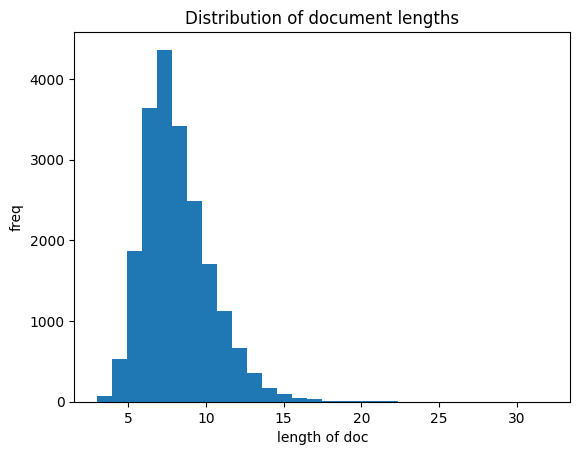

In [764]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(raw_df['size'], bins = 30)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Distribution of document lengths")
fig.show()

データを長さで濾過

In [765]:
## 長過ぎる語の除外 
print(f"max doc size: {max_doc_size}")
original_size = len(raw_df)
raw_df = raw_df[raw_df['size'] <= max_doc_size]
max_filtered_size = len(raw_df)
print(f"{original_size - max_filtered_size} cases removed due to max_doc_size")

## 短過ぎる語の除外
print(f"min doc size: {min_doc_size}")
raw_df = raw_df[raw_df['size'] >= min_doc_size]
min_filtered_size = len(raw_df)
print(f"{max_filtered_size - min_filtered_size} cases removed due to min_doc_size")
#
print(f"{original_size - min_filtered_size} cases removed in total")

max doc size: 13
383 cases removed due to max_doc_size
min doc size: 3
0 cases removed due to min_doc_size
383 cases removed in total


In [766]:
## 結果の検査 1
for type in types:
    print(raw_df[type].value_counts(sort = True))

spell
1    20236
Name: count, dtype: int64
sound
0    20236
Name: count, dtype: int64


In [767]:
## 結果の検査 2
for lang in selected_langs:
    print(raw_df[lang].value_counts(sort = True).sort_index())

arabic
0    19241
1      995
Name: count, dtype: int64
czech
0    19250
1      986
Name: count, dtype: int64
dutch
0    19271
1      965
Name: count, dtype: int64
esperato
0    20236
Name: count, dtype: int64
english
0    16088
1     4148
Name: count, dtype: int64
finnish
0    19256
1      980
Name: count, dtype: int64
french
0    19251
1      985
Name: count, dtype: int64
german
0    19459
1      777
Name: count, dtype: int64
greek
0    19262
1      974
Name: count, dtype: int64
hebrew
0    19237
1      999
Name: count, dtype: int64
hungarian
0    19245
1      991
Name: count, dtype: int64
icelandic
0    19391
1      845
Name: count, dtype: int64
irish
0    19271
1      965
Name: count, dtype: int64
italian
0    19247
1      989
Name: count, dtype: int64
romanian
0    20236
Name: count, dtype: int64
russian
0    19263
1      973
Name: count, dtype: int64
spanish
0    19245
1      991
Name: count, dtype: int64
swahili
0    19531
1      705
Name: count, dtype: int64
turkish
0    19250
1

英語事例の割合補正

In [768]:
## 統合: 割合補正を適用
eng_reduct_factor = 0.22
if balanced:
    try:
        eng_df = raw_df[raw_df['english'] == 1]
        non_eng_df = raw_df[raw_df['english'] == 0]
        eng_reduced_df = eng_df.sample(round(len(eng_df) * eng_reduct_factor))
        raw_df = pd.concat([eng_reduced_df, non_eng_df])
    except KeyError:
        pass
#
raw_df

,form,freq,spell,sound,arabic,czech,dutch,esperato,english,finnish,...,italian,romanian,russian,spanish,swahili,turkish,welsh,language,family,size
1250,#equality#,1.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,english,english,10
430,#brain#,1.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,english,english,7
2022,#jewelry#,1.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,english,english,9
4190,#window#,1.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,english,english,8
2984,#provisions#,1.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,english,english,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,#trwyn#,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7
996,#lluosog#,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,9
997,#dicter#,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,8
998,#hawliad#,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,9


In [769]:
## 結果の検査 3: 言語ごとの事例数の分布を確認
lang_counts = {}
for lang in selected_langs:
    lang_count = raw_df['language'].value_counts().sort_index()
    lang_counts[lang] = lang_count[1]
    if verbose:
        print("")
        print(lang_count)

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_75423/2537727318.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_75423/2537727318.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_75423/2537727318.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipy

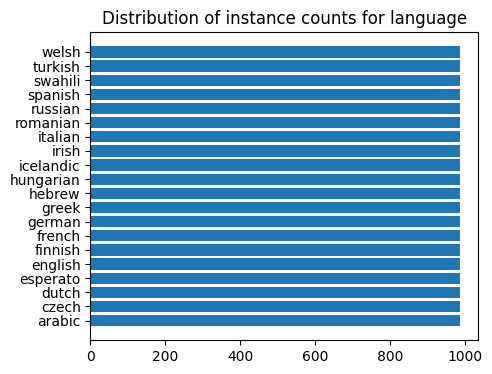

In [770]:
## 言語ごとの事例数の分布を確認
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize = (5,4))
lang_labels = [ str(lang) for lang in lang_counts.keys() ]
plt.barh(range(len(lang_labels)), lang_counts.values(), tick_label = lang_labels)
plt.title(f"Distribution of instance counts for language")
plt.show()

In [771]:
## 順序のランダマイズし，基本データを決定
import sklearn.utils
main_df = sklearn.utils.shuffle(raw_df)

In [772]:
# name the shared variable
bases = main_df[doc_type]
bases

290       #işareti#
499        #nafasi#
760      #praktijk#
675         #العمر#
671       #módszer#
           ...     
685     #collector#
936        #gagner#
157          #over#
347         #cyfan#
4095         #ward#
Name: form, Length: 17001, dtype: object

# n-grams の生成

In [773]:
## n-gram 追加のルーチン
def add_ngrams(dfx, n_for_ngram: int = 2, skippy: bool = False, prefix: str = "", seg_joint: str = "", gap_mark: str = "…", max_distance = None, inclusive: bool = True, inclusion_degree = None, check: bool = False):
    """
    add n-gram col to df
    """
    import gen_ngrams
    source_var_name = f"{prefix}1gram"
    if skippy:
        target_var_name = f"sk{prefix}{n_for_ngram}gram"
    else:
        target_var_name = f"{prefix}{n_for_ngram}gram"
    if check:
        print(f"source_var_name: {source_var_name}")
        print(f"target_var_name: {target_var_name}")
    ## define souruce var
    unigrams = dfx[source_var_name]
    ## generate n-grams
    if skippy:
        ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, max_distance = max_distance, sep = seg_joint, missing_mark = gap_mark, check = check) for x in unigrams ]
    else:
        ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]

    ## n-gram を包括的にする場合
    if inclusive:
        sub_var_name = f"{prefix}{n_for_ngram - 1}gram"
        sub_ngrams = dfx[sub_var_name]
        if inclusion_degree is None:
            ngrams = [ [*a, *b ] for a, b in zip(ngrams, sub_ngrams) ]
        elif inclusion_degree >= 0:
            min_size = (n_for_ngram - inclusion_degree)
            assert min_size >= 0
            ngrams = [ [ *a, *[ x for x in b if len(x) >= min_size ] ] for 
                      a, b in zip(ngrams, sub_ngrams) ]
        else:
            raise "ValueError"

    ## n-gram列の追加
    dfx[target_var_name] = ngrams
    print(dfx[target_var_name])

In [774]:
## 1gram 列の追加
unigrams = bases.apply(lambda x: re.split(r"", x))

## remove null elements
unigrams = [ [ u for u in x if len(u) > 0 ] for x in unigrams ]
if verbose:
    random.sample(unigrams, 5)
#
main_df['1gram'] = unigrams
main_df['1gram']

290           [#, i, ş, a, r, e, t, i, #]
499              [#, n, a, f, a, s, i, #]
760        [#, p, r, a, k, t, i, j, k, #]
675                 [#, ا, ل, ع, م, ر, #]
671           [#, m, ó, d, s, z, e, r, #]
                      ...                
685     [#, c, o, l, l, e, c, t, o, r, #]
936              [#, g, a, g, n, e, r, #]
157                    [#, o, v, e, r, #]
347                 [#, c, y, f, a, n, #]
4095                   [#, w, a, r, d, #]
Name: 1gram, Length: 17001, dtype: object

In [775]:
## 2gram の追加
add_ngrams(main_df, n_for_ngram = 2, seg_joint = "", check = False)

290     [#i, iş, şa, ar, re, et, ti, i#, #, i, ş, a, r...
499     [#n, na, af, fa, as, si, i#, #, n, a, f, a, s,...
760     [#p, pr, ra, ak, kt, ti, ij, jk, k#, #, p, r, ...
675         [#ا, ال, لع, عم, مر, ر#, #, ا, ل, ع, م, ر, #]
671     [#m, mó, ód, ds, sz, ze, er, r#, #, m, ó, d, s...
                              ...                        
685     [#c, co, ol, ll, le, ec, ct, to, or, r#, #, c,...
936     [#g, ga, ag, gn, ne, er, r#, #, g, a, g, n, e,...
157                [#o, ov, ve, er, r#, #, o, v, e, r, #]
347         [#c, cy, yf, fa, an, n#, #, c, y, f, a, n, #]
4095               [#w, wa, ar, rd, d#, #, w, a, r, d, #]
Name: 2gram, Length: 17001, dtype: object


In [776]:
## 3gram の追加
add_ngrams(main_df, n_for_ngram = 3, seg_joint = "", inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

290     [#iş, işa, şar, are, ret, eti, ti#, #i, iş, şa...
499     [#na, naf, afa, fas, asi, si#, #n, na, af, fa,...
760     [#pr, pra, rak, akt, kti, tij, ijk, jk#, #p, p...
675     [#ال, الع, لعم, عمر, مر#, #ا, ال, لع, عم, مر, ر#]
671     [#mó, mód, óds, dsz, sze, zer, er#, #m, mó, ód...
                              ...                        
685     [#co, col, oll, lle, lec, ect, cto, tor, or#, ...
936     [#ga, gag, agn, gne, ner, er#, #g, ga, ag, gn,...
157              [#ov, ove, ver, er#, #o, ov, ve, er, r#]
347     [#cy, cyf, yfa, fan, an#, #c, cy, yf, fa, an, n#]
4095             [#wa, war, ard, rd#, #w, wa, ar, rd, d#]
Name: 3gram, Length: 17001, dtype: object


In [777]:
## 4gram の追加
add_ngrams(main_df, n_for_ngram = 4, seg_joint = "", inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

290     [#işa, işar, şare, aret, reti, eti#, #iş, işa,...
499     [#naf, nafa, afas, fasi, asi#, #na, naf, afa, ...
760     [#pra, prak, rakt, akti, ktij, tijk, ijk#, #pr...
675     [#الع, العم, لعمر, عمر#, #ال, الع, لعم, عمر, مر#]
671     [#mód, móds, ódsz, dsze, szer, zer#, #mó, mód,...
                              ...                        
685     [#col, coll, olle, llec, lect, ecto, ctor, tor...
936     [#gag, gagn, agne, gner, ner#, #ga, gag, agn, ...
157                [#ove, over, ver#, #ov, ove, ver, er#]
347     [#cyf, cyfa, yfan, fan#, #cy, cyf, yfa, fan, an#]
4095               [#war, ward, ard#, #wa, war, ard, rd#]
Name: 4gram, Length: 17001, dtype: object


In [778]:
## 5gram の追加
if "5gram" in lda_term_type:
    add_ngrams(main_df, n_for_ngram = 5, seg_joint = "", inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

In [779]:
## skippy 2gram の追加
add_ngrams(main_df, skippy = True, n_for_ngram = 2, seg_joint = "", inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, max_distance = max_gap_size, check = False)

290     [#i, #…ş, #…a, #…r, #…e, #…t, #…i, #…#, iş, i…...
499     [#n, #…a, #…f, #…a, #…s, #…i, #…#, na, n…f, n…...
760     [#p, #…r, #…a, #…k, #…t, #…i, #…j, #…k, pr, p…...
675     [#ا, #…ل, #…ع, #…م, #…ر, #…#, ال, ا…ع, ا…م, ا…...
671     [#m, #…ó, #…d, #…s, #…z, #…e, #…r, #…#, mó, m…...
                              ...                        
685     [#c, #…o, #…l, #…l, #…e, #…c, #…t, #…o, co, c…...
936     [#g, #…a, #…g, #…n, #…e, #…r, #…#, ga, g…g, g…...
157     [#o, #…v, #…e, #…r, #…#, ov, o…e, o…r, o…#, ve...
347     [#c, #…y, #…f, #…a, #…n, #…#, cy, c…f, c…a, c…...
4095    [#w, #…a, #…r, #…d, #…#, wa, w…r, w…d, w…#, ar...
Name: sk2gram, Length: 17001, dtype: object


In [780]:
## skippy 3gram の追加
add_ngrams(main_df, skippy = True, n_for_ngram = 3, seg_joint = "", inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, max_distance = max_gap_size, check = False)

290     [#iş, #i…a, #i…r, #i…e, #i…t, #i…i, #i…#, #…şa...
499     [#na, #n…f, #n…a, #n…s, #n…i, #n…#, #…af, #…a…...
760     [#pr, #p…a, #p…k, #p…t, #p…i, #p…j, #p…k, #…ra...
675     [#ال, #ا…ع, #ا…م, #ا…ر, #ا…#, #…لع, #…ل…م, #…ل...
671     [#mó, #m…d, #m…s, #m…z, #m…e, #m…r, #m…#, #…ód...
                              ...                        
685     [#co, #c…l, #c…l, #c…e, #c…c, #c…t, #c…o, #…ol...
936     [#ga, #g…g, #g…n, #g…e, #g…r, #g…#, #…ag, #…a…...
157     [#ov, #o…e, #o…r, #o…#, #…ve, #…v…r, #…v…#, #…...
347     [#cy, #c…f, #c…a, #c…n, #c…#, #…yf, #…y…a, #…y...
4095    [#wa, #w…r, #w…d, #w…#, #…ar, #…a…d, #…a…#, #…...
Name: sk3gram, Length: 17001, dtype: object


In [781]:
## skippy 4gram の追加
add_ngrams(main_df, skippy = True, n_for_ngram = 4, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, seg_joint = "", max_distance = max_gap_size, check = False)

290     [#işa, #iş…r, #iş…e, #iş…t, #iş…i, #iş…#, #i…a...
499     [#naf, #na…a, #na…s, #na…i, #na…#, #n…fa, #n…f...
760     [#pra, #pr…k, #pr…t, #pr…i, #pr…j, #pr…k, #p…a...
675     [#الع, #ال…م, #ال…ر, #ال…#, #ا…عم, #ا…ع…ر, #ا…...
671     [#mód, #mó…s, #mó…z, #mó…e, #mó…r, #mó…#, #m…d...
                              ...                        
685     [#col, #co…l, #co…e, #co…c, #co…t, #co…o, #c…l...
936     [#gag, #ga…n, #ga…e, #ga…r, #ga…#, #g…gn, #g…g...
157     [#ove, #ov…r, #ov…#, #o…er, #o…e…#, #o…r#, #…v...
347     [#cyf, #cy…a, #cy…n, #cy…#, #c…fa, #c…f…n, #c…...
4095    [#war, #wa…d, #wa…#, #w…rd, #w…r…#, #w…d#, #…a...
Name: sk4gram, Length: 17001, dtype: object


In [782]:
## skippy 5gram の追加
if "5gram" in lda_term_type:
    add_ngrams(main_df, skippy = True, n_for_ngram = 5, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, seg_joint = "", max_distance = max_gap_size, check = False)

In [783]:
main_df[['1gram', '2gram', '3gram', '4gram', 'sk2gram', 'sk3gram', 'sk4gram']]

,1gram,2gram,3gram,4gram,sk2gram,sk3gram,sk4gram
290,"[#, i, ş, a, r, e, t, i, #]","[#i, iş, şa, ar, re, et, ti, i#, #, i, ş, a, r...","[#iş, işa, şar, are, ret, eti, ti#, #i, iş, şa...","[#işa, işar, şare, aret, reti, eti#, #iş, işa,...","[#i, #…ş, #…a, #…r, #…e, #…t, #…i, #…#, iş, i…...","[#iş, #i…a, #i…r, #i…e, #i…t, #i…i, #i…#, #…şa...","[#işa, #iş…r, #iş…e, #iş…t, #iş…i, #iş…#, #i…a..."
499,"[#, n, a, f, a, s, i, #]","[#n, na, af, fa, as, si, i#, #, n, a, f, a, s,...","[#na, naf, afa, fas, asi, si#, #n, na, af, fa,...","[#naf, nafa, afas, fasi, asi#, #na, naf, afa, ...","[#n, #…a, #…f, #…a, #…s, #…i, #…#, na, n…f, n…...","[#na, #n…f, #n…a, #n…s, #n…i, #n…#, #…af, #…a…...","[#naf, #na…a, #na…s, #na…i, #na…#, #n…fa, #n…f..."
760,"[#, p, r, a, k, t, i, j, k, #]","[#p, pr, ra, ak, kt, ti, ij, jk, k#, #, p, r, ...","[#pr, pra, rak, akt, kti, tij, ijk, jk#, #p, p...","[#pra, prak, rakt, akti, ktij, tijk, ijk#, #pr...","[#p, #…r, #…a, #…k, #…t, #…i, #…j, #…k, pr, p…...","[#pr, #p…a, #p…k, #p…t, #p…i, #p…j, #p…k, #…ra...","[#pra, #pr…k, #pr…t, #pr…i, #pr…j, #pr…k, #p…a..."
675,"[#, ا, ل, ع, م, ر, #]","[#ا, ال, لع, عم, مر, ر#, #, ا, ل, ع, م, ر, #]","[#ال, الع, لعم, عمر, مر#, #ا, ال, لع, عم, مر, ر#]","[#الع, العم, لعمر, عمر#, #ال, الع, لعم, عمر, مر#]","[#ا, #…ل, #…ع, #…م, #…ر, #…#, ال, ا…ع, ا…م, ا…...","[#ال, #ا…ع, #ا…م, #ا…ر, #ا…#, #…لع, #…ل…م, #…ل...","[#الع, #ال…م, #ال…ر, #ال…#, #ا…عم, #ا…ع…ر, #ا…..."
671,"[#, m, ó, d, s, z, e, r, #]","[#m, mó, ód, ds, sz, ze, er, r#, #, m, ó, d, s...","[#mó, mód, óds, dsz, sze, zer, er#, #m, mó, ód...","[#mód, móds, ódsz, dsze, szer, zer#, #mó, mód,...","[#m, #…ó, #…d, #…s, #…z, #…e, #…r, #…#, mó, m…...","[#mó, #m…d, #m…s, #m…z, #m…e, #m…r, #m…#, #…ód...","[#mód, #mó…s, #mó…z, #mó…e, #mó…r, #mó…#, #m…d..."
...,...,...,...,...,...,...,...
685,"[#, c, o, l, l, e, c, t, o, r, #]","[#c, co, ol, ll, le, ec, ct, to, or, r#, #, c,...","[#co, col, oll, lle, lec, ect, cto, tor, or#, ...","[#col, coll, olle, llec, lect, ecto, ctor, tor...","[#c, #…o, #…l, #…l, #…e, #…c, #…t, #…o, co, c…...","[#co, #c…l, #c…l, #c…e, #c…c, #c…t, #c…o, #…ol...","[#col, #co…l, #co…e, #co…c, #co…t, #co…o, #c…l..."
936,"[#, g, a, g, n, e, r, #]","[#g, ga, ag, gn, ne, er, r#, #, g, a, g, n, e,...","[#ga, gag, agn, gne, ner, er#, #g, ga, ag, gn,...","[#gag, gagn, agne, gner, ner#, #ga, gag, agn, ...","[#g, #…a, #…g, #…n, #…e, #…r, #…#, ga, g…g, g…...","[#ga, #g…g, #g…n, #g…e, #g…r, #g…#, #…ag, #…a…...","[#gag, #ga…n, #ga…e, #ga…r, #ga…#, #g…gn, #g…g..."
157,"[#, o, v, e, r, #]","[#o, ov, ve, er, r#, #, o, v, e, r, #]","[#ov, ove, ver, er#, #o, ov, ve, er, r#]","[#ove, over, ver#, #ov, ove, ver, er#]","[#o, #…v, #…e, #…r, #…#, ov, o…e, o…r, o…#, ve...","[#ov, #o…e, #o…r, #o…#, #…ve, #…v…r, #…v…#, #…...","[#ove, #ov…r, #ov…#, #o…er, #o…e…#, #o…r#, #…v..."
347,"[#, c, y, f, a, n, #]","[#c, cy, yf, fa, an, n#, #, c, y, f, a, n, #]","[#cy, cyf, yfa, fan, an#, #c, cy, yf, fa, an, n#]","[#cyf, cyfa, yfan, fan#, #cy, cyf, yfa, fan, an#]","[#c, #…y, #…f, #…a, #…n, #…#, cy, c…f, c…a, c…...","[#cy, #c…f, #c…a, #c…n, #c…#, #…yf, #…y…a, #…y...","[#cyf, #cy…a, #cy…n, #cy…#, #c…fa, #c…f…n, #c…..."


# LDA

In [784]:
## bots and target_labels
bots = main_df[lda_term_type]
target_labels = main_df['language'] # needed for labeled LDA

## LDA by GenSim

In [785]:
#!pip install -U scipy

In [786]:
## DTM 構築
from gensim.corpora.dictionary import Dictionary
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<9390 unique tokens: ['#', '#i', '#…#', '#…a', '#…e']...>


In [787]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction)

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
print(f"abuse filter: {term_abuse_rate}")
print(f"min freq filter: {term_min_freq}")
if apply_term_filtering:
    diction_copy.filter_extremes(no_below = term_min_freq, no_above = term_abuse_rate)

## check
print(diction_copy)

abuse filter: 0.9
min freq filter: 3
Dictionary<6677 unique tokens: ['#i', '#…#', '#…a', '#…e', '#…i']...>


In [788]:
## Corpus (gensim の用語では corpus) の構築
corpus = [ diction.doc2bow(bot) for bot in bots ]
check = False
if check:
    sample_n = 5
    print(random.sample(corpus, sample_n))
#
print(f"Number of documents: {len(corpus)}")

Number of documents: 17001


LDA モデルの構築

In [789]:
## LDA モデルの構築
print(f"Building LDA model with n_topics: {n_topics}")
from gensim.models import LdaModel as LDAmodel
gensim_lda_model = LDAmodel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
print(gensim_lda_model) # print(..)しないと中身が見れない

Building LDA model with n_topics: 20
LdaModel<num_terms=9390, num_topics=20, decay=0.5, chunksize=2000>


In [790]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in gensim_lda_model.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,topic 12,topic 13,topic 14,topic 15,topic 16,topic 17,topic 18,topic 19,topic 20
0,o…#,h…#,i…#,e…#,k…#,т…#,b…#,e…#,o#,t…#,a…#,#,#,l…#,l#,n…#,#,a#,s#,k#
1,d…#,t#,n…#,e#,e#,ь#,r…#,n#,o…#,i…#,ar,τ…#,y…#,p…#,i#,z…#,ا…#,a…#,j…#,u#
2,r…#,#,g…#,er,#,#,e…#,en,e…o,a…#,a,ρ…#,v…#,á…#,и…#,nd,ة#,u…#,#,#
3,#,u…#,#,r…#,u…#,а…#,s…#,n…#,k…#,a#,#…a,ο…#,#…#,#,#,e…#,ل…#,#,ä…#,ו…#
4,o,o…#,in,e…e,r…#,ть,#,e…n,i…#,a…t,a…a,ε…#,י…#,l,l…#,d…#,#…#,m…#,ä#,ek
5,#…o,t…#,i…i,i…e,i#,л…#,a#,i…n,#,ta,r…#,α#,y#,p…a,о…#,#,ي…#,a…a,s…#,m…k
6,s#,p…#,n#,i…#,s…#,о…#,h#,e…e,o,t,#,σ…#,ל…#,ll,il,é…#,ر…#,u…a,as,ה#
7,or,o…t,g#,l…#,r#,а#,r…s,#,i…o,t…a,ra,ς#,y,a…#,н…#,s…#,م…#,a,é#,#…#
8,o#,h,u…#,a…e,#…#,с…#,es,n,#…o,#…t,an,α…#,י#,la,li,n,ال,#…a,t…ä,r…k
9,d#,#…#,i…n,c…#,k,е…#,b…e,s…n,a…o,t#,r#,ν…#,#…y,#…l,е…#,e…d,و…#,ma,l…s,l…k


LDAvis の実行

In [791]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()
#
lda_used     = gensim_lda_model
corpus_used  = corpus
diction_used = diction

## 実行パラメター: MMDS かtSNEを選ぶと "JSON object is too complex" error を回避できる 
LDAvis_use_MMDS  = False
LDAvis_use_tSNE  = False
if LDAvis_use_MMDS:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)
elif LDAvis_use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

## LDA by TomotoPy

In [792]:
## install TomotoPy if necessary
#!conda install tomotopy -y # fails
#!pip install -U tomotopy
#!conda update conda -y

In [ ]:
## LDA モデル作成
if use_TomotoPy:
    import tomotopy as tp
    ## setting for term filtering
    min_cf_val = 0
    if apply_term_filtering:
        min_cf_val = term_min_freq
    ##
    print(f"len(bots): {len(bots)}")
    print(f"min_cf_val: {min_cf_val}")
    print(f"rm_top_val: {rm_top_val}")
    ## apply
    if use_labeled_LDA:
        tomoto_lda_model = tp.LLDAModel(k = n_topics, seed = 1234, min_cf = min_cf_val)
        for text, label in zip(bots, target_labels):
            if check:
                print(f"text: {text}; label: {label}")
            tomoto_lda_model.add_doc(text, labels = label)
    else:
        tomoto_lda_model = tp.LDAModel(k = n_topics, seed = 1234, min_cf = min_cf_val)
        for text in bots:
            tomoto_lda_model.add_doc(text)
#
tomoto_lda_model

len(bots): 17001
min_cf_val: 3
rm_top_val: 1700


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_75423/2583254682.py:17: DeprecationWarning:

`tomotopy.LLDAModel` is deprecated. Please use `tomotopy.PLDAModel` instead.

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_75423/2583254682.py:21: RuntimeWarning:

`labels` should be an iterable of str.



In [794]:
## LDA モデルの訓練
tomoto_lda_model.train(iter = 100)

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_75423/793251112.py:2: RuntimeWarning:

The training result may differ even with fixed seed if `workers` != 1.



In [795]:
## print terms by topics
topic_dict = {}
for k in range(tomoto_lda_model.k):
    topic_dict[k] = tomoto_lda_model.get_topic_words(k, top_n = 10)
##
topic_df = pd.DataFrame.from_dict(topic_dict)
topic_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"(sı, 0.0103491535410285)","(е…к, 0.004678227938711643)","(غ…#, 0.030274221673607826)","(ρε, 0.006368797272443771)","(h…ú, 0.015055234543979168)","(б…т, 0.013080814853310585)","(v#, 0.010446848347783089)","(ו…ר, 0.005364187527447939)","(ط#, 0.018554016947746277)","(wn, 0.01817380264401436)","(jk, 0.018167033791542053)","(اء, 0.011107143945991993)","(ئ…#, 0.006718419957906008)","(м#, 0.015136043541133404)","(ημ, 0.005964215844869614)","(γ…ο, 0.01831504888832569)","(h…ä, 0.01794852316379547)","(tz, 0.03623068705201149)","(ný, 0.010484026744961739)","(ñ…#, 0.0399383045732975)"
1,"(ş, 0.0103491535410285)","(ля, 0.004678227938711643)","(gá, 0.02365276962518692)","(λ…ι, 0.006033626850694418)","(úi, 0.014414655044674873)","(oa, 0.011697400361299515)","(á…y, 0.010171955451369286)","(ק, 0.0053175464272499084)","(يد, 0.01608056016266346)","(iw, 0.017225686460733414)","(l…ð, 0.017318185418844223)","(ت#, 0.009135032072663307)","(ق…ة, 0.006718419957906008)","(x…e, 0.013913052156567574)","(ν…ο, 0.00585772143676877)","(ψ…#, 0.01831504888832569)","(mä, 0.01683676615357399)","(ü…l, 0.017600420862436295)","(ě#, 0.00941630732268095)","(ía, 0.033449143171310425)"
2,"(ş…a, 0.01003237534314394)","(н…а, 0.0046371943317353725)","(lg, 0.022233886644244194)","(λ…ν, 0.005866041406989098)","(i…ú, 0.013934219256043434)","(б, 0.01157163456082344)","(eá, 0.010171955451369286)","(#…ח, 0.005270905327051878)","(uj, 0.013607102446258068)","(d…w, 0.016593609005212784)","(t…ð, 0.0152809526771307)","(ما, 0.00840846449136734)","(ير, 0.0066445996053516865)","(ő…#, 0.013913052156567574)","(ν…ε, 0.005484991241246462)","(by, 0.017733711749315262)","(n…ä, 0.016201475635170937)","(wo, 0.016565406695008278)","(o…ý, 0.009319242089986801)","(ño, 0.02845747582614422)"
3,"(ü#, 0.009926781989634037)","(и…и, 0.0046371943317353725)","(pé, 0.017977239564061165)","(ιο, 0.0057543180882930756)","(a…ú, 0.01345378439873457)","(б…ь, 0.011320104822516441)","(é…é, 0.009622168727219105)","(יר, 0.0052242642268538475)","(k…f, 0.013297921046614647)","(sg, 0.015171435661613941)","(a…ð, 0.014771644026041031)","(ذ…#, 0.008304668590426445)","(ت…ا, 0.0066445996053516865)","(щ…#, 0.012995808385312557)","(σ…μ, 0.005484991241246462)","(ρ…φ, 0.014245684258639812)","(ät, 0.015883831307291985)","(g…b, 0.015012886375188828)","(ký, 0.008736850693821907)","(e_, 0.01747581548988819)"
4,"(ık, 0.009926781989634037)","(в…н, 0.0045551275834441185)","(ز#, 0.017031317576766014)","(λ…σ, 0.005642594303935766)","(ló, 0.01345378439873457)","(х…#, 0.011068575084209442)","(r…á, 0.009622168727219105)","(י…י, 0.005084340926259756)","(j…z, 0.013297921046614647)","(y… , 0.015013416297733784)","(s…ð, 0.014092565514147282)","(ج, 0.007681896444410086)","(با, 0.006275495979934931)","(zt, 0.011619944125413895)","(ν…ν, 0.005431744270026684)","(γ…ς, 0.013955015689134598)","(k…ä, 0.015566186979413033)","(ß…#, 0.015012886375188828)","(ř, 0.008251523599028587)","(r…ó, 0.01647748239338398)"
5,"(ç…k, 0.009821189567446709)","(ы, 0.0045551275834441185)","(nm, 0.016085395589470863)","(δ…α, 0.005307423882186413)","(tó, 0.01265305932611227)","(об, 0.010817045345902443)","(c…á, 0.009347275830805302)","(לי, 0.005037700291723013)","(l…ő, 0.012988738715648651)","(fy, 0.014855396933853626)","(e…ð, 0.013753026723861694)","(ح…ة, 0.007681896444410086)","(ا…ب, 0.006201675161719322)","(lv, 0.011619944125413895)","(νε, 0.005272002890706062)","(γά, 0.01279233954846859)","(vä, 0.015407364815473557)","(z…h, 0.01397787220776081)","(ět, 0.008154458366334438)","(_…r, 0.01647748239338398)"
6,"(l…ı, 0.009821189567446709)","(с#, 0.0045551275834441185)","(רג, 0.013247632421553135)","(άσ, 0.005307423882186413)","(s…ó, 0.01265305932611227)","( …t, 0.010817045345902443)","(zá, 0.009347275830805302)","(ך#, 0.004944418091326952)","(f…z, 0.012679556384682655)","('…#, 0.014065301045775414)","(jó, 0.01307394914329052)","(ك#, 0.007578101009130478)","(ية, 0.006201675161719322)","(öt, 0.010396952740848064)","(ίτ, 0.00

In [796]:
## prepare data for pyLDAvis
topic_term_dists = np.stack(
    [tomoto_lda_model.get_topic_word_dist(k) for k in range(tomoto_lda_model.k)] # k is effective n_topics
    )
#
doc_topic_dists = np.stack(
    [doc.get_topic_dist() for doc in tomoto_lda_model.docs]
    )
doc_topic_dists /= doc_topic_dists.sum(axis = 1, keepdims = True)
#
doc_lengths = np.array([len(doc.words) for doc in tomoto_lda_model.docs])
#
tomoto_diction = list(tomoto_lda_model.used_vocabs)
#
term_frequency = tomoto_lda_model.used_vocab_freq

In [797]:
import pyLDAvis
prepared_data = pyLDAvis.prepare(
        topic_term_dists, 
        doc_topic_dists, 
        doc_lengths, 
        tomoto_diction, 
        term_frequency,
        start_index = 1,
        sort_topics = False 
    )

In [798]:
pyLDAvis.display(prepared_data)

In [799]:
if save_files:
    pyLDAvis.save_html(prepared_data, 'ldavis.html')

# Doc 分類

In [800]:
## encode docs by topics
tomoto_lda_encoding = []
check = False
for doc_id, doc in enumerate(tomoto_lda_model.docs):
    if check:
        print(f"{doc_id}: {doc}")
    doc_enc = doc.get_topic_dist()
    if check:
        print(doc_enc)
    tomoto_lda_encoding.append(doc_enc)
#
if check:
    tomoto_lda_encoding

In [801]:
## LDA モデルを使って doc をエンコード
print(f"get LDA encodings for documents")
check    = False
gensim_lda_encoding = [ ]
for i, row in main_df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[lda_term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = gensim_lda_model.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    gensim_lda_encoding.append([ e[-1] for e in enc ])
#
print(f"{len(gensim_lda_encoding)} documents are encoded")

get LDA encodings for documents
17001 documents are encoded


In [802]:
if check:
    pp.pprint(random.sample(gensim_lda_encoding, 2))

In [803]:
## select TomotoPy or GenSim encodings
if use_Tomoto_encoding:
    lda_encoding = tomoto_lda_encoding
else:
    lda_encoding = gensim_lda_encoding

In [804]:
## FastText を使ったエンコードの準備
from gensim.models import FastText

## build a model: for better comparison, vector_size should be equal to n_topics
print(f"get FastText encodings for documents")
## emulate sentences by concatenating character 1-grams by whitespaces
ft_term_seg_joint = " "
ft_corpus = [ ft_term_seg_joint.join(x) for x in main_df[ft_term_type] ]
random.sample(ft_corpus, 5)

get FastText encodings for documents


['#bíl bíll íll# #bí bíl íll ll#',
 '#puu puu# #pu puu uu#',
 '#ama amac mach ach# #am ama mac ach ch#',
 '#pos poss ossi ssib sibl ible ble# #po pos oss ssi sib ibl ble le#',
 '#vin vinn inna nna# #vi vin inn nna na#']

In [805]:
## FastText を使ったエンコード
ft_model = FastText(ft_corpus,
                    vector_size = ft_n_dims,
                    window = ft_window_size,
                    min_count = 1, sg = 1)
## ft_model は dict
ft_encoding = [ ft_model.wv[doc] for doc in ft_corpus ]
print(f"data size: {len(ft_encoding)}")
print(random.sample(ft_encoding, 3))

data size: 17001
[array([-1.2740196e-03, -1.1953589e-03, -8.5830945e-04,  7.7740091e-04,
       -1.3061484e-03,  1.3931413e-03,  2.6464995e-04,  6.0571142e-04,
       -1.0732618e-03,  8.8679670e-05, -4.1266688e-04,  5.1087007e-04,
        1.2274638e-03,  1.1727269e-03,  3.1820117e-03,  9.8848855e-04,
       -2.5918095e-03, -6.7929621e-04,  6.1047002e-04, -3.9478028e-04,
        4.6284458e-05,  2.9437249e-03,  5.8415777e-04,  1.3216152e-03,
       -1.0454892e-03, -6.4216601e-04, -1.6738320e-03, -2.5510744e-04,
        1.9633926e-03, -4.1219417e-04,  1.3135723e-03,  1.4556046e-03,
       -1.1995482e-03,  1.4302856e-03,  8.8718953e-04,  1.9381958e-03,
       -5.9832114e-04, -1.4208290e-03,  7.6992664e-04,  5.5653148e-04],
      dtype=float32), array([ 1.0398977e-03,  1.2699602e-03, -6.7516543e-05, -4.9708126e-04,
        9.5138537e-05, -6.3739886e-04,  1.4159665e-03,  6.2311016e-04,
       -1.5404801e-03, -1.9078206e-03, -1.1737507e-03,  1.8208761e-04,
       -1.7521787e-03,  1.2704027e-0

In [806]:
## doc_encoding の選択
if use_FastText:
    if use_LDA: ## LDA x FastText
        doc_encoding = [ np.concatenate([x, y], dtype = object) for x, y in zip(lda_encoding, ft_encoding) ]
    else: ## FastText only
        doc_encoding = ft_encoding
else: ## LDA only
    doc_encoding = lda_encoding
#
print(random.sample(doc_encoding, 1))
print(f"data size: {len(doc_encoding)}")

[array([0.0000000e+00, 0.0000000e+00, 2.5848980e-04, 0.0000000e+00,
       4.2001402e-04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       3.3186955e-04, 0.0000000e+00, 0.0000000e+00, 9.9858415e-01,
       4.0546583e-04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)]
data size: 17001


In [807]:
## df にenc 列の追加
#df['enc'] = [ list(map(lambda x: x[1], y)) for y in doc_encoding ]
main_df['enc'] = doc_encoding
main_df['enc']

290     [0.99695486, 0.00058333995, 0.00027165355, 0.0...
499     [0.0, 0.0, 0.0, 0.0, 0.13469452, 0.10883804, 0...
760     [0.00047389008, 0.00073889503, 0.0, 0.0, 0.0, ...
675     [0.0, 0.0, 0.0002871534, 0.0, 0.00046658886, 0...
671     [0.0, 0.00044369246, 0.00020662161, 0.0, 0.678...
                              ...                        
685     [0.0, 0.0, 0.0, 0.0, 0.1320802, 0.106725566, 0...
936     [0.0, 0.0, 0.10266012, 0.0, 0.0, 0.0, 0.367726...
157     [0.13847183, 0.21590692, 0.0, 0.0, 0.0, 0.0, 0...
347     [0.0, 0.0, 0.0, 0.0, 0.0, 0.12991084, 0.354419...
4095    [0.0, 0.0, 0.0, 0.0, 0.1320802, 0.106725566, 0...
Name: enc, Length: 17001, dtype: object

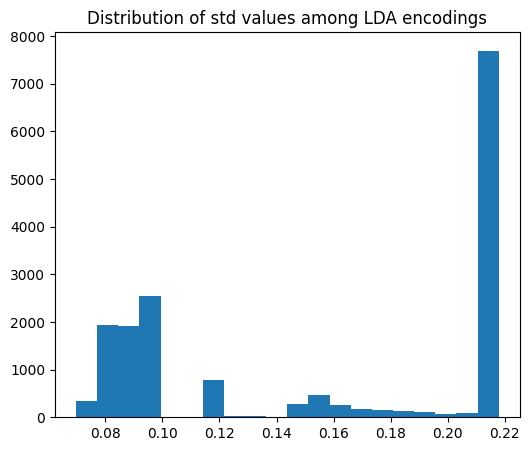

In [808]:
## 濾過前のエンコーディングのstd の分布を確認
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize = (6,5))
plt.hist([ np.std(x) for x in main_df['enc'] ], bins = 20)
plt.title(f"Distribution of std values among {encoding_method} encodings")
plt.show()

In [809]:
## 一様分布の事例を除外
import numpy as np

check = False
doc_enc = main_df['enc']
max_std = max([ np.std(x) for x in doc_enc])
if check:
    print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in doc_enc])
if check:
    print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-1]
print(f"std 2nd min: {second_min_std}")

std 1st min: 0.06967680901288986
std 2nd min: 0.2179161161184311


In [810]:
## df_filtered の定義
import numpy as np

print(f"{len(main_df)} instances before filtering")

## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
normalization_factor = 6
std_threshold = second_min_std / normalization_factor # 穏健な値を得るために 6で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]
## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
std_tested = [ False if np.std(x) < std_threshold else True for x in main_df['enc'] ]
df_filtered = main_df[ std_tested ]
print(f"Filtering leaves {len(df_filtered)} instances: ({len(main_df) - len(df_filtered)} instances removed)")

17001 instances before filtering
std_threshold: 0.03631935268640518
Filtering leaves 17001 instances: (0 instances removed)


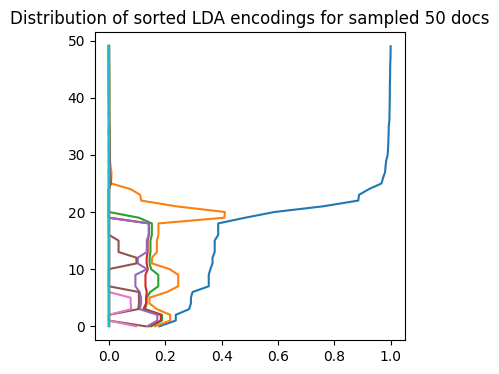

In [811]:
## doc エンコード値の分布を確認

sample_n = 50
E = sorted([ sorted(x, reverse = True) for x in df_filtered['enc'].sample(sample_n) ])
plt.figure(figsize = (4,4))
plt.plot(E, range(len(E)))
plt.title(f"Distribution of sorted {encoding_method} encodings for sampled {sample_n} docs")
plt.show()

In [812]:
df_filtered['language'].value_counts(sort = True).sort_index()

language
arabic       995
czech        986
dutch        965
english      913
finnish      980
french       985
german       777
greek        974
hebrew       999
hungarian    991
icelandic    845
irish        965
italian      989
russian      973
spanish      991
swahili      705
turkish      986
welsh        982
Name: count, dtype: int64

Dim Reduct 用の事例サンプリング

In [813]:
## Dim Reduct 用の事例サンプリング = doc_fit_df の定義
if doc_fit_sampling:
    doc_fit_df_original = df_filtered.copy()
    sample_n = round(len(doc_fit_df_original) * doc_fit_sampling_rate)
    doc_fit_df = doc_fit_df_original.sample(sample_n)
    print(f"doc_fit_df has {len(doc_fit_df)} rows after sampling")
else:
    doc_fit_df = df_filtered

doc_fit_df has 3400 rows after sampling


In [814]:
doc_fit_df.columns

Index(['form', 'freq', 'spell', 'sound', 'arabic', 'czech', 'dutch',
       'esperato', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew',
       'hungarian', 'icelandic', 'irish', 'italian', 'romanian', 'russian',
       'spanish', 'swahili', 'turkish', 'welsh', 'language', 'family', 'size',
       '1gram', '2gram', '3gram', '4gram', 'sk2gram', 'sk3gram', 'sk4gram',
       'enc'],
      dtype='object')

In [815]:
doc_fit_df['language'].value_counts(sort = True).sort_index()

language
arabic       205
czech        184
dutch        195
english      193
finnish      180
french       190
german       146
greek        193
hebrew       212
hungarian    195
icelandic    170
irish        203
italian      209
russian      188
spanish      209
swahili      147
turkish      187
welsh        194
Name: count, dtype: int64

In [816]:
doc_fit_df['family'].value_counts(sort = True).sort_index()

family
arabic       205
celtic       397
czech        184
english      193
finnish      180
germanic     511
greek        193
hebrew       212
hungarian    195
romance      608
russian      188
swahili      147
turkish      187
Name: count, dtype: int64

# UMAP を使った可視化 (3D)

In [817]:
## 必要に応じて
#!pip install -U ipywidgets

In [818]:
## UMAP を使った docs のグループ化
import numpy as np
import umap.umap_ as umap

## UMAP の生成
UMAP_3d = umap.UMAP(n_components = 3, random_state = 1, n_jobs = 1,
                    metric = umap_metric, n_neighbors = umap_n_neighbors, min_dist = umap_min_dist)

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_UMAP_3d = UMAP_3d.fit_transform(doc_enc)

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



In [819]:
%%capture --no-display

## Plotlyを使って UMAP の結果の可視化 (3D)
import plotly.graph_objects as go
import numpy as np

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family'
else:
    colored_var = 'language'

## umap_df を作成
X = zip(doc_UMAP_3d[:,0], doc_UMAP_3d[:,1], doc_UMAP_3d[:,2],
        doc_fit_df[colored_var], doc_fit_df[doc_type]) # zip(..)が必要
umap_df = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var, doc_type])

## draw
fig = go.Figure()
for lang_name in sorted(set(umap_df[colored_var])):
    # set marker size of the target domain
    traced = umap_df[ umap_df['language'] == lang_name ]
    fig.add_trace(
        go.Scatter3d(
            x = traced['D1'], y = traced['D2'], z = traced['D3'],
            name = lang_name.title(),
            mode = 'markers',
            marker = dict(size = 4, opacity = 0.8),
            marker_colorscale = color_palette, # worked??
            showlegend = True
        )
    )

## 3D 散布図にラベルを追加する処理は未実装
df_size = len(umap_df)
## title_header
title_header = f"UMAP 3D (metric: {umap_metric}; {umap_n_neighbors} neighbors; min dist: {umap_min_dist}) of {df_size} encodings via\n"
## title_body
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term:0 {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
#
title_val = title_header + title_body
fig.update_layout(title = dict(text = title_val, font_size = 12), autosize = False, width = 700, height = 700)
fig.show()

t-SNE の結果の可視化 (3D)

In [820]:
## tSNE の結果の可視化: Plotly を使った 3D 描画
perplexity_divider = 7
perplexity_max_val_factor = 0.33
#
draw_tSNE_results = False
if draw_tSNE_results:
    import numpy as np
    from sklearn.manifold import TSNE as tSNE
    import plotly.express as pex
    import plotly.graph_objects as go
    import matplotlib.pyplot as plt

    ## tSNE のパラメターを設定
    perplexity_max_val = round(len(doc_fit_df) * perplexity_max_val_factor)
    print(f"perplexity_max_val: {perplexity_max_val}")

    perplexity_increment = round(perplexity_max_val/perplexity_divider)
    print(f"perplexity_increment: {perplexity_increment}")

    ## tSNE を段階的に実行
    df_size = len(doc_fit_df)
    exit_after_step = 3 # 15 is largest enough to complete the all steps
    ppl_vals = enumerate(range(3, perplexity_max_val, perplexity_increment))
    for step, ppl_val in ppl_vals:
        ## 早期終了の判定
        if step >= exit_after_step:
            continue
        ## tSNE 事例の生成
        tSNE_3d_varied = tSNE(n_components = 3, random_state = 0, perplexity = ppl_val,
                            max_iter = 1000)

        ## データに適用
        doc_enc = np.array(list(doc_fit_df['enc']))
        doc_tSNE_3d_varied = tSNE_3d_varied.fit_transform(doc_enc)

        ## 色分けの単位を選択
        if color_lang_family:
            colored_var = 'family'
        else:
            colored_var = 'language'
        ##
        X = zip(doc_tSNE_3d_varied[:,0], doc_tSNE_3d_varied[:,1], doc_tSNE_3d_varied[:,2],
                doc_fit_df[colored_var]) # zip(..)が必要
        dfx = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var])
        ## 作図
        fig = go.Figure()
        for lang in np.unique(main_df[colored_var]):
            traced = dfx[dfx[colored_var] == lang]
            fig.add_trace(
                go.Scatter3d(
                    x = traced['D1'], y = traced['D2'], z = traced['D3'],
                    name = lang.title(), mode = 'markers', marker = dict(size = 3),
                    marker_colorscale = color_palette, # worked??
                    showlegend = True
                )
            )
        ## 題の指定
        title_header = f"t-SNE 3D map (ppl: {ppl_val}) of {df_size} encodings for <{doc_attr}> via\n"
        if use_FastText:
            if use_LDA:
                title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
            else:
                title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
        else:
            title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
        title_val = title_header + title_body
        fig.update_layout(title = dict(text = title_val, font_size = 13),
                        autosize = False, width = 600, height = 600)
        fig.show()

In [821]:
## 必要に応じて adjustText を道入
#!pip install -U adjustText

t-SNE の結果の可視化 (2D)

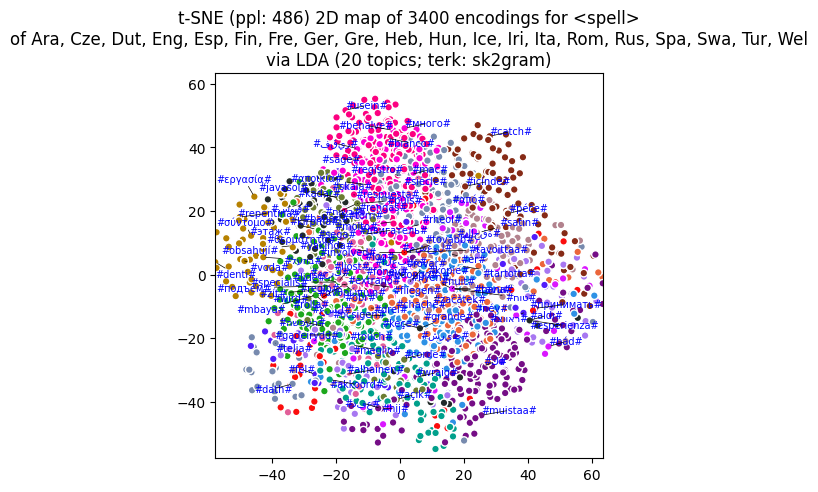

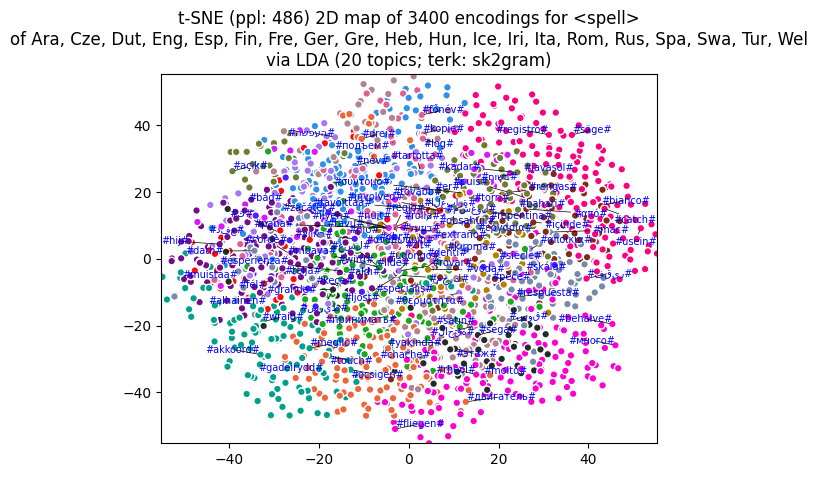

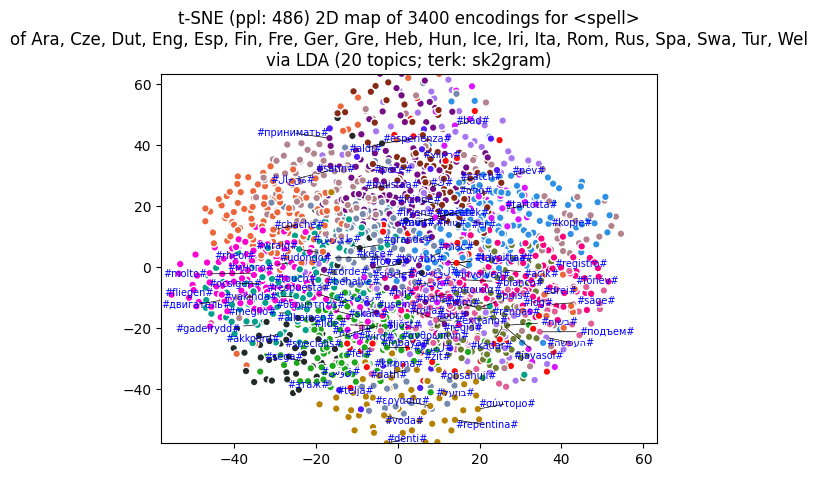

In [822]:
## tSNE の結果の可視化 (2D)
import numpy as np
from sklearn.manifold import TSNE as tSNE
import plotly
import plotly.express as pex
import matplotlib.pyplot as plt
from adjustText import adjust_text

## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## tSNE 事例の生成
perplexity_selected = round(len(doc_fit_df)/perplexity_divider)
doc_perplexity_val = perplexity_selected
doc_tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_selected, max_iter = 1000)

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family' # 一部の言語を celtic, germanic, romance, slavic 属に統合
else:
    colored_var = 'language' # 言語名そのまま

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_tSNE_3d = doc_tSNE_3d.fit_transform(doc_enc)

## plot_df の定義
X = zip(doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2], doc_fit_df[colored_var]) # zip(..)が必要
plot_df = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var])

## 描画
plt.figure(figsize = (5, 5))

## 配色
plt.set_colors = pex.colors.qualitative.Plotly

## labeling
lab_sampling_rate = 0.03
lab_sample_n = round(len(doc_fit_df) * lab_sampling_rate)
sampled_keys = [ doc[:max_doc_size] for doc in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]    

## 描画
check = False
early_exit = False
for step, roll in enumerate([ np.roll([0,1,2], -i) for i in range(0,3) ]):
    ## 早期停止の判定
    if early_exit:
        if step > 0:
            continue
    ## 通常処理
    if check:
        print(roll)
    X, Y = plot_df.iloc[:, roll[0]], plot_df.iloc[:, roll[1]]
    gmax = max(X.max(), Y.max())
    gmin = min(X.min(), Y.min())
    plt.xlim(gmin, gmax)
    plt.ylim(gmin, gmax)

    ## 配色
    colormap = color_palette # == pex.colors.qualitative.Light24
    lang_list = list(set(doc_fit_df[colored_var]))
    cmapped = [ colormap[lang_list.index(lang)] for lang in plot_df[colored_var] ]
    
    ## 作図
    scatter = plt.scatter(X, Y, s = 30, c = cmapped, edgecolors = 'w')

    ## 文字を表示する事例のサンプリング
    texts = [ ]
    ## labels の生成
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 7, color = 'blue'))
        ## label に repel を追加: adjustText package の導入が必要
    adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #
    title_header = f"t-SNE (ppl: {perplexity_selected}) 2D map of {len(doc_fit_df)} encodings for <{doc_attr}>\n"
    title_body = f"of {', '.join([ l.title() for l in sorted([ l[:3] for l in selected_langs])])}\n"
    title_tail = f"via LDA ({n_topics} topics; terk: {lda_term_type})"          
    plt.title(title_header + title_body + title_tail)
    #plt.legend(df['language'])
    plt.show()

# DBSCAN を使ったクラスタリング

In [823]:
## DBSCAN を使ったクラスタリング
from sklearn.cluster import DBSCAN

DBSCAN_uses_UMAP = True
if DBSCAN_uses_UMAP:
    dbscan_source = doc_UMAP_3d
else:
    dbscan_source = doc_tSNE_3d

## eps は事例ごとに調節が必要
min_samples_val  = 2
## looking for optimal eps val compatible with color palette
max_n_clusters   = 24 # This depends on the differetiation in color palette used
dbscan_clustered = None
cluster_ids      = None
max_val          = 5 # needs to be effectively large
eps_vals = np.arange(max_val, 0.005, -0.05)

print(f"Looking for the optimal eps val...")
check = False
for eps_val in eps_vals:
    if check:
        print(f"testing eps = {eps_val:0.4f}")
    dbscan_clustered_local = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
    cluster_ids_local = dbscan_clustered_local.labels_
    if check:
        print(f"result: {np.unique(cluster_ids_local)}")
    try:
        assert len(np.unique(cluster_ids_local)) <= max_n_clusters
        dbscan_clustered = dbscan_clustered_local
        cluster_ids = cluster_ids_local
    except AssertionError:
        break
#
print(f"final result: {np.unique(cluster_ids)}")

Looking for the optimal eps val...
final result: [None]


In [824]:
#!conda install seaborn -y

In [825]:
%%capture --no-display

import seaborn as sns
import matplotlib.pyplot as plt

## 日本語表示のための設定
#plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux の場合は別のフォントを指定

## 凡例の文字の大きさを指定
param_vals = {'legend.fontsize': 7, 'legend.handlelength': 2}
plt.rcParams.update(param_vals)

## 描画
fig = plt.figure(figsize = (6, 6))
#
d1, d2 = dbscan_source[:,0], dbscan_source[:,1]
sns.scatterplot(x = d1, y = d2, hue = [ f"cluster {l}" for l in dbscan_clustered.labels_ ]) # requires Searborn

## 文字を表示する事例のサンプリング
relative = True
if relative:
    lab_sampling_rate = 0.04 # サンプリング率の指定
    lab_sample_n = round(lab_sampling_rate * len(plot_df))
else:
    lab_sample_n = 30 # 絶対数の指定

## 事例名の生成
texts = [ ]
sampled_keys = [ x[:max_doc_size] for x in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]
for x, y, s in zip(d1, d2, sampled_keys):
    texts.append(plt.text(x, y, s, size = 7, color = 'blue'))

## label に repel を追加: adjustText package の導入が必要
adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    
## 題名を指定
## used_domains
used_lang_list = f"{', '.join([ l.title() for l in [ l[:3] for l in selected_langs] ])}"
## title_header
df_size = len(plot_df)
if DBSCAN_uses_UMAP:
    title_header = f"2D view of UMAP (metric: {umap_metric}, n_neighbors: {umap_n_neighbors}; min_dist: {umap_min_dist}) for {df_size} encodings for <{doc_attr}> \nin {used_lang_list} via\n"
else:
    title_header = f"2D view of t-SNE (ppl: {doc_perplexity_val}) for {df_size} encodings for <{doc_attr}> in\n{used_lang_list} via\n"
## title_val
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_boday = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_val = f"LDA ({n_topics} topics; term: {lda_term_type})"
## clustering_method
clustering_method = f"\nclustered by DBSCAN (eps: {eps_val:0.3f}; min_samples: {min_samples_val})"
#
title_val = title_header + title_body + clustering_method
plt.title(title_val)
plt.show()
## 局在の程度は character 1-gram, (skippy) 2-gram, (skippy) 3-gram のどれを使うかで違って来る．

AttributeError: 'NoneType' object has no attribute 'labels_'

<Figure size 600x600 with 0 Axes>

# co-clusteredness に基づく言語間類似度の計算

In [826]:
## co-clusteredness に基づく言語間類似度の計算
import pandas as pd
from sklearn.cluster import DBSCAN

#DBSCAN_uses_UMAP = True # tSNE は有効でないようだ
if DBSCAN_uses_UMAP:
    dbscan_source = doc_UMAP_3d
else:
    dbscan_source = doc_tSNE_3d

## eps, min_samples は事例ごとに調節が必要
min_samples_val = 2

## 精度を上げるために，クラスター数を多目にする
scaling_factor = 5
max_n_clusters_for_correl = round(len(selected_langs) * scaling_factor)
print(f"max_n_clusters_for_correl")

print(f"Looking for the optimal value for eps...")
check = False
x_dbscan_clustered = None
x_cluster_ids = None
max_val = 5 # needs to be effectively large
eps_vals = np.arange(max_val, 0.005, -0.05)
for eps_val in eps_vals:
    if check:
        print(f"testing eps = {eps_val:0.4f}")
    x_dbscan_clustered_local = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
    x_cluster_ids_local = x_dbscan_clustered_local.labels_
    if check:
        print(f"result: {np.unique(x_cluster_ids_local)}")
    try:
        assert len(np.unique(x_cluster_ids_local)) <= max_n_clusters_for_correl
        x_dbscan_clustered = x_dbscan_clustered_local
        x_cluster_ids = x_cluster_ids_local
    except AssertionError:
        break
#
print(f"final result: {np.unique(x_cluster_ids)}")

## clusterごとに言語の帰属数を集計
selector_var = 'language'
bindings = zip(doc_fit_df[doc_type], doc_fit_df[selector_var], x_dbscan_clustered.labels_)
binding_df = pd.DataFrame(bindings, columns = ['form', selector_var, 'cluster'])

selector_names = sorted(set(binding_df[selector_var]))
print(f"selector_names: {selector_names}")

cluster_ids = sorted(set(binding_df['cluster']))
print(f"cluster ids: {cluster_ids}")

clusterwise_counts = { selector_name : None for selector_name in selector_names }
for selector_name in selector_names:
    counts = [ ]
    selected = binding_df[ binding_df[selector_var] == selector_name ]
    for i, cluster_id in enumerate(cluster_ids):
        matched = selected[ selected['cluster'] == cluster_id ]
        n_matches = len(matched)
        if n_matches == 0:
            counts.append(0)
        else:
            counts.append(int(n_matches))
    clusterwise_counts[selector_name] = counts

## クラスターでの生起個数の間の相関を計算
clusterwise_counts_df = pd.DataFrame.from_dict(clusterwise_counts) ## Truly versatile
clusterwise_counts_df

max_n_clusters_for_correl
Looking for the optimal value for eps...
final result: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97]
selector_names: ['arabic', 'czech', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hungarian', 'icelandic', 'irish', 'italian', 'russian', 'spanish', 'swahili', 'turkish', 'welsh']
cluster ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]


,arabic,czech,dutch,english,finnish,french,german,greek,hebrew,hungarian,icelandic,irish,italian,russian,spanish,swahili,turkish,welsh
0,0,0,0,0,0,0,89,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,111,0,0,0,0,0,0,0,0,0,0,0,0,0
2,58,0,0,0,0,2,4,2,2,14,5,3,2,3,6,7,1,0
3,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0
95,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0


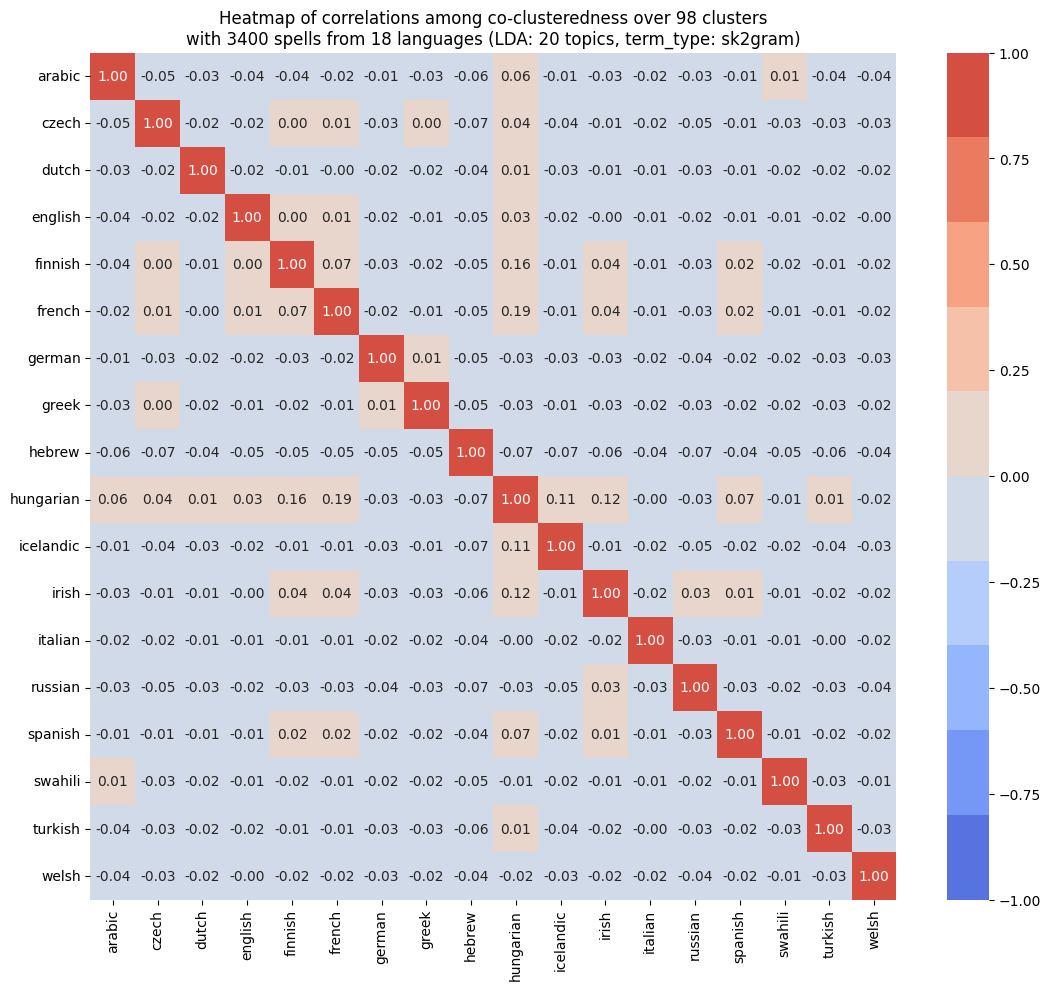

In [827]:
## Heatmap で可視化
import seaborn as sns

counts_df_normalized = (clusterwise_counts_df - clusterwise_counts_df.min())/(clusterwise_counts_df.max() - clusterwise_counts_df.min())
corr_df = counts_df_normalized.corr()
#corr_df.sort_index(axis = 0, inplace = True)
#corr_df.sort_index(axis = 1, inplace = True)

n_selectors = len(selector_names)
fig = plt.figure(figsize = (round(n_selectors * 0.7), round(n_selectors * 0.6)))
sns.heatmap(corr_df, cmap = sns.color_palette('coolwarm', 10),
            annot = True, fmt = '.2f', vmin = -1, vmax = 1)

title_val = f"Heatmap of correlations among co-clusteredness over {len(cluster_ids)} clusters\nwith {len(dbscan_source)} {doc_attr}s from {n_selectors} {selector_var}s (LDA: {n_topics} topics, term_type: {lda_term_type})"
plt.title(title_val)
plt.show()

# 階層クラスタリング

In [828]:
## 階層クラスタリングのための事例のサンプリング

df_size = len(doc_fit_df)
hc_sampling_rate = 0.05 # 大きくし過ぎると図が見にくい
hc_sample_n = round(df_size * hc_sampling_rate)
doc_hc_df = doc_fit_df.sample(hc_sample_n)
##
print(f"{hc_sample_n} rows are sampled")
doc_hc_df[colored_var].value_counts(sort = True).sort_index()

170 rows are sampled


language
arabic       11
czech         6
dutch        11
english      15
finnish      10
french        1
german        6
greek         7
hebrew        9
hungarian     7
icelandic    13
irish        12
italian      14
russian       7
spanish      11
swahili       9
turkish      13
welsh         8
Name: count, dtype: int64

階層クラスタリングの実行

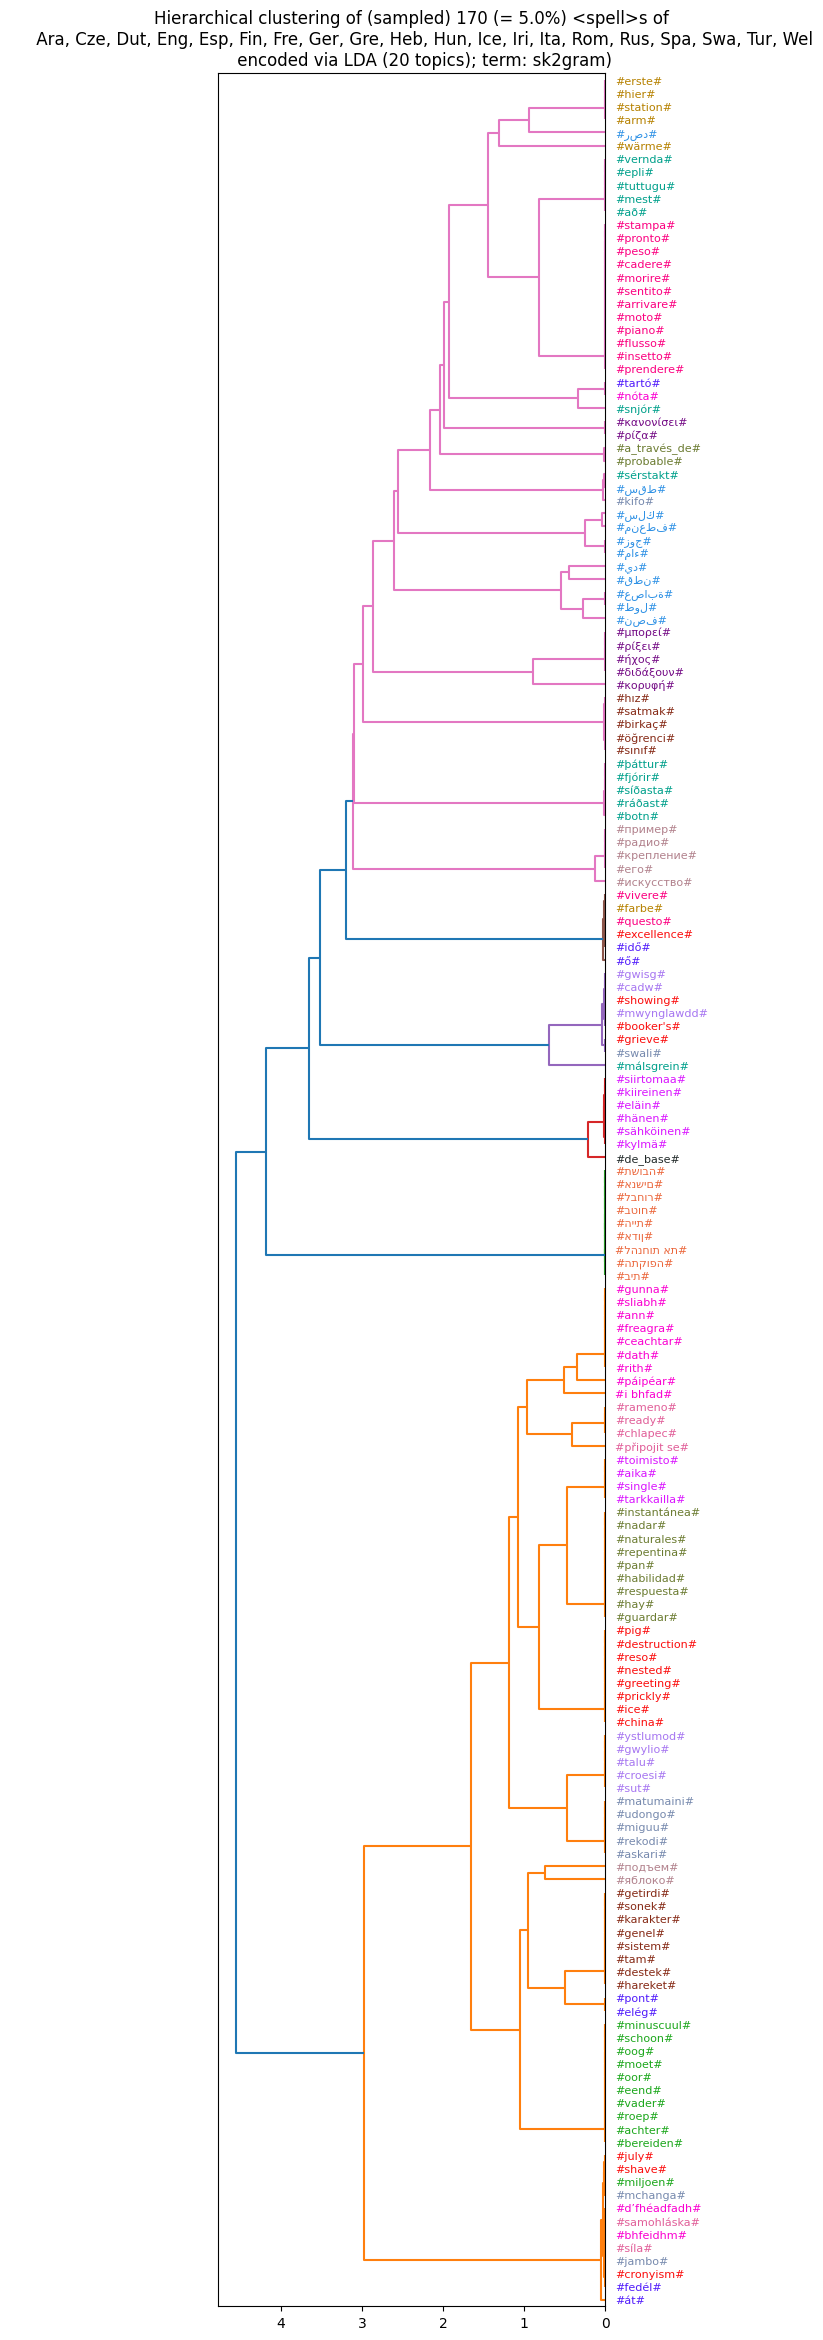

In [829]:
## doc 階層クラスタリングの実行

import numpy as np
import plotly
import matplotlib.pyplot as plt
## 次の設定は arabic, bengali が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## 描画サイズの指定
plt.figure(figsize = (5, round(len(doc_hc_df) * 0.17))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_size] for x in list(doc_hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
doc_hc_enc = list(doc_hc_df['enc'])
doc_linkage = linkage(doc_hc_enc, method = 'ward', metric = 'euclidean')
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(doc_hc_df)} (= {100 * hc_sampling_rate}%) <{doc_attr}>s of\n \
    {', '.join([ l.title()[:3] for l in sorted(selected_langs)])}\n \
    encoded via LDA ({n_topics} topics); term: {lda_term_type})")

## ラベルに language に対応する色を付ける
lang_colors = { lang_name : i for i, lang_name in enumerate(np.unique(doc_hc_df[colored_var])) }
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    form = ticker.get_text()
    row = doc_hc_df.loc[doc_hc_df[doc_type] == form]
    lang = row[colored_var].to_string().split()[-1] # trick
    try:
        lang_id = lang_colors[lang]
    except (TypeError, KeyError):
        print(f"color encoding error at: {lang}")
    #
    ticker.set_color(color_palette[lang_id])
#
plt.show()
## A few Turkish words will be partially garbled.

# Topics の調査

In [830]:
if not run_topic_analysis:
    import sys
    sys.exit()

SystemExit: 

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:
if use_TomotoPy:
    lda_model = tomoto_lda_model
else:
    lda_model = gensim_lda_model
##
print(lda_model)

In [ ]:
#dir(lda_model)

In [ ]:
## LDA がD に対して生成した topics の弁別性を確認
if use_TomotoPy:
    #topic_dist = doc_topic_dists # defined earlier
    topic_dist = np.stack(
        [doc.get_topic_dist() for doc in tomoto_lda_model.docs]
    )
else:
    topic_dist = lda_model.get_topics()
##
topic_dist

In [ ]:
## 検査 1: topic ごとに分布の和を取る
print(topic_dist.sum(axis = 1))

In [ ]:
## 検査 2: 総和を求める: n_topics にほぼ等しいなら正常
print(topic_dist.sum())

In [ ]:
## term エンコード値の分布を確認
if verbose:
    import matplotlib.pyplot as plt

    plt.figure(figsize = (4,4))
    df_size = len(topic_dist)
    sampling_rate = 0.5
    sample_n = round(df_size * sampling_rate)
    topic_sampled = random.sample(list(topic_dist), sample_n)

    T = sorted([ sorted(x, reverse = True) for x in topic_sampled ])
    plt.plot(T, range(len(T)))
    plt.title(f"Distribution of sorted values ({sample_n} samples) for term encoding")
    plt.show()

In [ ]:
## tSNE を使った topics のグループ化 (3D)
from sklearn.manifold import TSNE as tSNE
import numpy as np

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
ppl_val = round(len(topic_dist) * top_perplexity_reduct_rate)
top_tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = ppl_val, max_iter = 1000)

## データに適用
top_tSNE_3d_fitted = top_tSNE_3d.fit_transform(np.array(topic_dist))

In [ ]:
## Plotlyを使って tSNE の結果の可視化 (3D)
import plotly.graph_objects as go
top_fitted = top_tSNE_3d_fitted
fig = go.Figure(data = [go.Scatter3d(
        x = top_fitted[:,0], y = top_fitted[:,1], z = top_fitted[:,2],
                                     mode = 'markers')
                                     ])

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"t-SNE 3D map of LDA topics (#topics: {n_topics}; doc: {doc_attr}; term: {lda_term_type})"
fig.update_layout(autosize = False, width = 600, height = 600, title = title_val)
fig.show()